# BootstrapEstimator: bootstrap estimates for machine learning

The basic idea behind the [bootstrap method](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is to generate a large number of bootstrap replicas from a dataset and calculate the model performance for each separately. This allows the calculation of statistical metrics for the model such as a confidence interval for the accuracy.

Although a relatively simple task, [this class](https://github.com/ttmarkka/mlbootstrap.git) makes this process automatic, inclding generating a plot. The use and conventions are aimed to follow those in [sklearn](https://scikit-learn.org/stable/) as closely as possible. 

In this notebook we show the usage with the help of data from [Kaggle Titanic competition](https://www.kaggle.com/c/titanic/data?select=test.csv).

We also introduce an implementation for a time series data, for which the usual approach using the `train_test_split` from [sklearn](https://scikit-learn.org/stable/) is problematic due to data leakage. As an auxiliary function we define `train_test_split_ts` appropriate for time series data. Although there already exists a similar object *sklearn.model_selection.TimeSeriesSplit* the functionality will differ slightly in a way more suited to our purposes.

In [1]:
import pandas as pd

df = pd.read_csv('data/data.csv')
df.head(5)

,Pclass,Age,Fare,Soc_class,FamSize,Survived_yes,Sex_male,Cabin_yes,Embarked_Q,Embarked_S
0,3,22.0,7.2500,0,1,0,1,0,0,1
1,1,38.0,71.2833,0,1,1,0,1,0,0
2,3,26.0,7.9250,0,0,1,0,0,0,1
3,1,35.0,53.1000,0,1,1,0,1,0,1
4,3,35.0,8.0500,0,0,0,1,0,0,1


## 1 Minimal working example
As a bare bones example we show how to generate bootsrapped statistics for the accuracy (*sklearn.metrics.accuracy_score*) of a DecisionTreeClassifer trained to predict the <font color='red'>'Survived_yes'</font> column of the data. Note that we have simply chosen *accuracy_score*, but all other metrics available from from *sklearn.metrics* (as well as one's own) are equally valid.

In [2]:
from BootstrapEstimator import BootstrapEstimator
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import accuracy_score

# Data
X, y = df.drop(['Survived_yes'], axis = 1), df['Survived_yes']

# Create an instance of the class
BE_tree = BootstrapEstimator(DTC(max_depth = 5))

# Generate bootstrapped datasets, fit and calculate the accuracy for a test/training split for each replica
BE_tree.fit_calculate(X, y, accuracy_score)

###  The results for the training set, the test set as well as the classifier are available as attributes:
 Specifically, `.results['train']` and `.results['test']` given as numpy arrays and the classifier is accessible as `.classifier`.

In [3]:
import numpy as np

# Calculate some relvant statistics with numpy
for key in {'train', 'test'}:
    print('mean({}): {:.4}'.format(key, np.mean(BE_tree.results[key])))
    print('std({}): {:.4}'.format(key, np.std(BE_tree.results[key])))

mean(test): 0.8294
std(test): 0.02708
mean(train): 0.8721
std(train): 0.01443


In [4]:
# The classifier has the usual sklearn methods
print('Model parameters: {}'.format(BE_tree.classifier.get_params()))

Model parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


### Histogram for the accuracies of test and training set available as a method

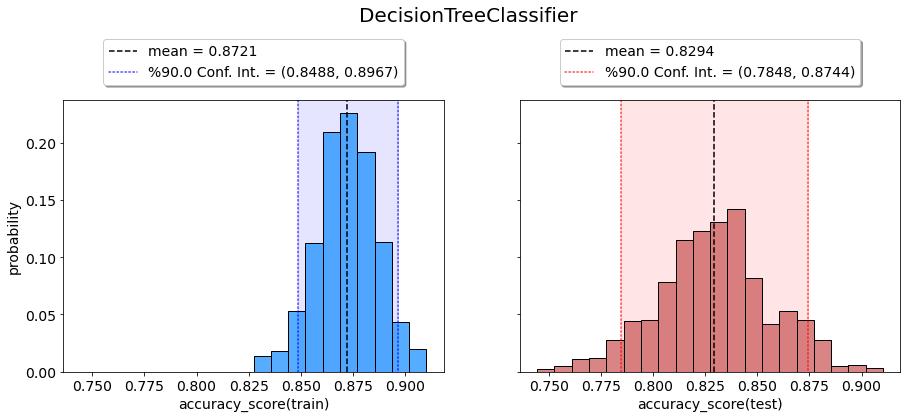

In [5]:
BE_tree.plot()

## 2 Example with all available functionality

Here we will train a linear regressor to predict the <font color='red'>'Age'</font> while setting all the available variables for `.fit_calculate` and `.plot()` explicitly.

The available parameters are:
- **scaler: function, default = None**. Allows preprocessing of training data.
- **n: int, default = 1000.** The number of bootsrapped replicas that are generated.
- **frac: float, default = 1.0.** The size (length with respect to initial data) of a bootstrapped replica dataset. Gets passed to *pandas.DataFrame.sample*.
- **test_size: float or int, default = 0.25.** Gets passed into *sklearn.model_selection.train_test_split*.
- **random_state: int, default = None.** Pass an int for reproducability (like in *sklearn*).
- **stratify: array-like, default = None.** Gets passed into *sklearn.model_selection.train_test_split*.
- **verbose: bool, default = False.** Prints the percentage done and the time remaining. Useful for larger datasets and models that take a while to train.
- **time_series: bool, default = False.** Switch time series functionality on/off. **See section 3 of this notebook for more information.**

In [6]:
from BootstrapEstimator import BootstrapEstimator
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Data
X, y = df.drop(['Age'], axis = 1), df['Age']

# Create an instance of the class
BE_linear = BootstrapEstimator(LR())

# Create an instance of MinMaxScaler (although for this example not really needed)
sclr = MinMaxScaler()

# Using a self-defined function for the accuracy
def root_mean_squared_error(x,y):
    return mean_squared_error(x,y)**(1/2)

# Fit and calculate the RMS, with parameters as explained above
BE_linear.fit_calculate(X, y, root_mean_squared_error, scaler = sclr, n = 10000, frac = 0.9,
                        test_size = 0.1, random_state = 1, stratify = None, verbose = True,
                        time_series = False)

done                                                                                                    


### Available histogram parameters

- **bins: int, default = 20.** The maximum number of bins in a panel. Since binwidth is fixed, the panels don't have equal bin numbers.
- **conf: float, default = 0.9.** The confidence interval centered around the mean.
- **stat: {'count', 'frequency', 'density', 'probability'}, default = 'probability'.** Gets passed in into *seaborn.histplot*.

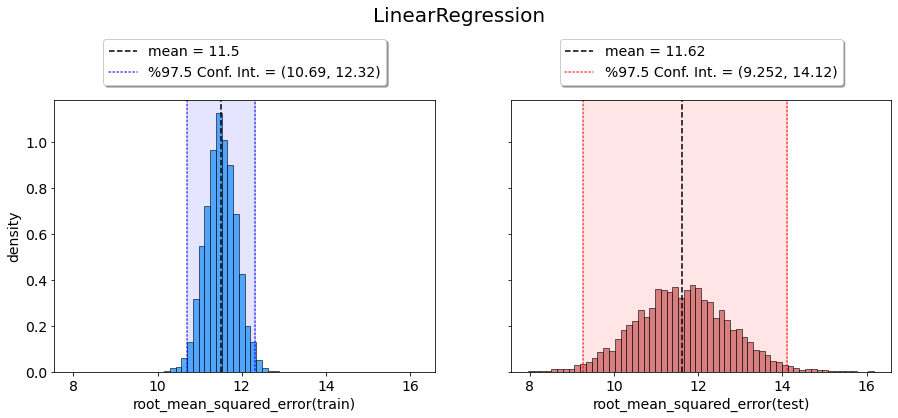

In [7]:
BE_linear.plot(bins = 60, conf = 0.975, stat = 'density')

## 3 Time series implementation

For times series data, using `train_test_split` from  [sklearn](https://scikit-learn.org/stable/) leads to data leakage from the train set to the test set due uniform shuffling. Here we define a train test split where the data is split into subsets, each of which is then split into a train and test set in a causal manner. For the [sklearn](https://scikit-learn.org/stable/) object with similar functionality, see *sklearn.model_selection.TimeSeriesSplit*. 

**Note that this approach is more sensitive to the size of the original data as effectively the boostrapping takes place at the level of the subsets.**

In [8]:
from BootstrapEstimator import train_test_split_ts

#### DataFrame with datetime indexes

In [9]:
np.random.seed(2)

dg = pd.DataFrame({'nums_1': np.arange(1000)+ np.random.randint(700, size = 1000)})
dg['nums_2'] = np.arange(1000)
t0 = pd.to_datetime('20210404', format='%Y%m%d', errors='coerce')
dt = pd.Timedelta('1 days')
dg.index = [t0 + i*dt for i in range(len(dg))]
dg.head()

,nums_1,nums_2
2021-04-04,168,0
2021-04-05,528,1
2021-04-06,495,2
2021-04-07,587,3
2021-04-08,538,4


### Parameters/inputs for `train_test_split_ts(X, y, ...)`
Outputs four lists, schematically **X_train, X_test, y_train, y_test**, which each contains *n_splits* subsets of the full data.

- **X: pandas.DataFrame or pandas.DataSeries**. The predictor needs to be a dataframe or a series with datetime indexes.
- **y: pandas.DataFrame or pandas.DataSeries**. The target needs to be a dataframe or a series with datetime indexes.
- **test_size: float, [0, 1], default = 0.2**. Fraction of the test set with respect to the train set
- **n_splits: int, default = 3.** Number of equally sized subsets of the full data.

### Illustration of `train_test_split_ts` (test_size = 0.2 and n_splits = 3)

In [12]:
X, y = dg['nums_2'], dg['nums_1']
X_train, X_test, y_train, y_test = train_test_split_ts(X, y, test_size = 0.2, n_splits = 3)

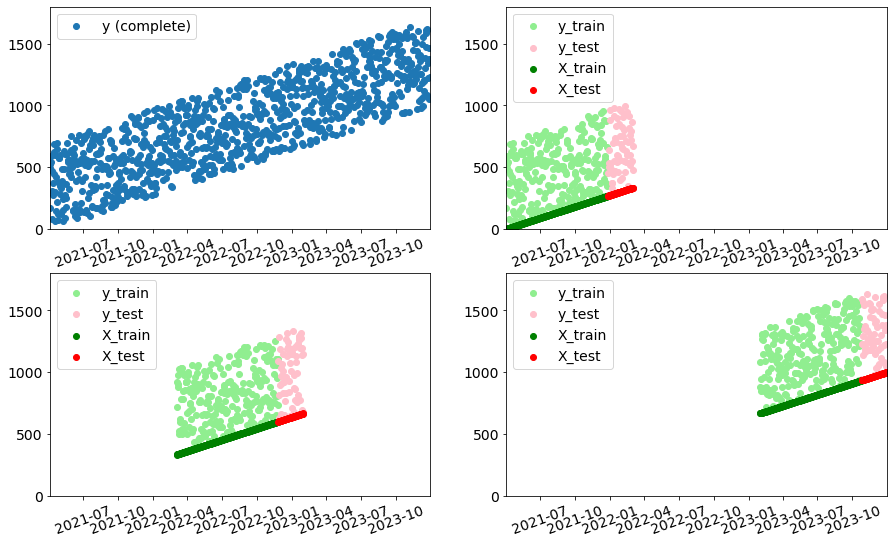

In [13]:
import matplotlib.pyplot as plt

# Complete data
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15,9))
ax[0,0].scatter(dg.index, dg['nums_1'], label = 'y (complete)')
ax[0,0].legend(loc = 2)
ax[0,0].set_ylim([0, 1800])
ax[0,0].set_xlim(t0, t0+dt*len(dg))
ax[0,0].tick_params(axis = 'x', rotation=20)

# Time ordered subsets
i = 0
ax = ax.reshape(1,-1)
for a in ax[0,1:]:
    a.scatter(X_train[i].index, y_train[i], color = 'lightgreen', label = 'y_train')
    a.scatter(X_test[i].index, y_test[i], color = 'pink', label = 'y_test')
    a.scatter(X_train[i].index, X_train[i], color = 'green', label = 'X_train')
    a.scatter(X_test[i].index, X_test[i], color = 'red', label = 'X_test')
    a.set_ylim([0, 1800])
    a.legend(loc = 2)
    a.set_xlim(t0, t0+dt*len(dg))
    a.tick_params(axis = 'x', rotation = 20)
    i += 1

plt.show()

### Bootstrapping a time series
The time series implementation (`time_series = True`) has an additional parameter:
- **n_splits: int, default = 3.** Number of equally sized subsets of the full data. Gets passed into `train_test_split_ts`.

The other available parameters are as before (however stratifying is not possible):
- **scaler: function, default = None**. Allows preprocessing of training data.
- **n: int, default = 1000.** The number of bootsrapped replicas that are generated.
- **frac: float, default = 1.0.** The size (length with respect to initial data) of a bootstrapped replica dataset. Gets passed to *pandas.DataFrame.sample*.
- **test_size: float or int, default = 0.25.** Gets passed into *sklearn.model_selection.train_test_split*.
- **random_state: int, default = None.** Pass an int for reproducability (like in *sklearn*).
- **verbose: bool, default = False.** Prints the percentage done and the time remaining. Useful for larger datasets and models that take a while to train.
- **time_series: bool, default = False.** Switch time series functionality on/off. 

In [14]:
# Data
X, y = dg['nums_2'], dg['nums_1']

# Create an instance of the class
BE_linear = BootstrapEstimator(LR())

# Fit and calculate the RMS, with parameters as explained above
BE_linear.fit_calculate(X, y, root_mean_squared_error, n = 1500, test_size = 0.3,
                             verbose = True, random_state = 2, time_series = True, n_splits = 4)

done                                                                                                    


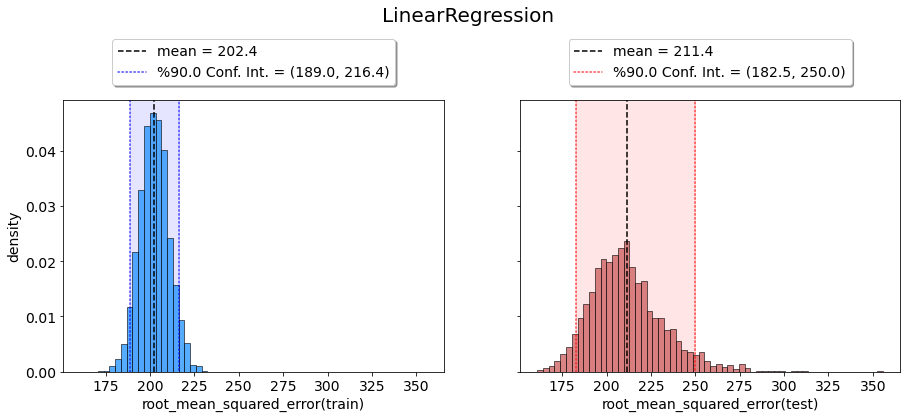

In [15]:
BE_linear.plot(bins = 60, conf = 0.9, stat = 'density')

#### Local library versions

In [14]:
import sklearn as sk
import seaborn as sns
import matplotlib as mp
print(pd.__version__, np.__version__, sk.__version__, mp.__version__, sns.__version__)

1.1.3 1.19.2 0.23.2 3.3.2 0.11.0
